## Defining Models

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

class Chain_1D():
    def __init__(self, N:int, r:float, u:float, h:float):
        self.N = N
        self.theta = np.array([np.pi*2*random.random() for i in range(N)])
        self.J_L = np.add(np.random.choice([-1.0, 1.0], size=(N), p=(0.5-u/2, 0.5+u/2)), h*np.ones((N)))
        self.J_R = np.add(np.random.choice([-1.0, 1.0], size=(N), p=(0.5-u/2, 0.5+u/2)), h*np.ones((N)))

    def reset(self):
        self.theta = np.copy(np.array([np.pi*2*random.random() for i in range(self.N)]))
    
    def evolve_timestep(self, dt: float):
        theta_dot = np.array([(self.J_R[i]*np.sin(self.theta[(i+1)%self.N] - self.theta[i]) + self.J_L[(i-1)%self.N]*np.sin(self.theta[(i-1)%self.N] - self.theta[i])) for i in range(self.N)])
        self.theta = np.add(self.theta, dt*theta_dot)

    def evolve_and_record(self, t:float, dt:float):
        self.reset()
        n_T = int(t//dt)
        theta_history =[]
        for timestep in range(n_T):
            if timestep%int(1/dt) == 0:
                theta_history.append(self.theta%(np.pi))
            self.evolve_timestep(dt)
        return np.array(theta_history)
    
    def evolve_and_record_all(self, t:float, dt:float):
        n_T = int(t//dt)
        theta_history =[]
        for timestep in range(n_T):
            theta_history.append(self.theta%(np.pi))
            self.evolve_timestep(dt)
        return np.array(theta_history)
    
    def record_at_steady_state(self, T:float, dT:float, t:float, dt:float, record_incriment=1.0, mod_pi = True):
        self.reset()

        #Evolve to steady state
        n_T = int(T//dT)
        for timestep in range(n_T):
            self.evolve_timestep(dT)
        
        n_t = int(t//dt)
        theta_history = []
        for timestep in range(n_t):
            if timestep%int(record_incriment/dt) == 0:
                if mod_pi:
                    theta_history.append(self.theta%(np.pi))
                else:
                    theta_history.append(self.theta%(2*np.pi))
            self.evolve_timestep(dt)
        return np.array(theta_history)
         

class Chain_2D(Chain_1D):
    def __init__(self, N: int, r: float, kappa: float):
        self.N = N
        self.theta = np.array([[np.pi*2*random.random() for i in range(N)] for j in range(N)])
        J_tilde_R = np.array([np.random.choice([-1.0, 1.0], size=(N), p=(0.5, 0.5)) for j in range(N)])
        J_tilde_L = np.array([[np.random.choice([J_tilde_R[j][i], -J_tilde_R[i][j]], p=(0.5+r/2, 0.5-r/2)) for i in range(N)] for j in range(N)])
        J_tilde_U = np.array([np.random.choice([-1.0, 1.0], size=(N), p=(0.5, 0.5)) for j in range(N)])
        J_tilde_D = np.array([[np.random.choice([J_tilde_U[j][i], -J_tilde_U[i][j]], p=(0.5+r/2, 0.5-r/2)) for i in range(N)] for j in range(N)])

        self.couplings_R = np.add(kappa*np.copy(J_tilde_R), (1-kappa)*np.ones((N,N)))
        self.couplings_L = np.add(kappa*np.copy(J_tilde_L), (1-kappa)*np.ones((N,N)))
        self.couplings_U = np.add(kappa*np.copy(J_tilde_U), (1-kappa)*np.ones((N,N)))
        self.couplings_D = np.add(kappa*np.copy(J_tilde_D), (1-kappa)*np.ones((N,N)))
        

    def evolve_timestep(self, dt: float):
        for i in range(self.N):
            for j in range(self.N):
                theta_dot_ij = (self.couplings_L[(i-1)%self.N][j]*np.sin(self.theta[(i-1)%self.N][j] - self.theta[i][j])
                + self.couplings_R[i][j]*np.sin(self.theta[(i+1)%self.N][j] - self.theta[i][j])
                + self.couplings_U[i][(j-1)%self.N]*np.sin(self.theta[i][(j-1)%self.N] - self.theta[i][j])
                + self.couplings_D[i][j]*np.sin(self.theta[i][(j+1)%self.N] - self.theta[i][j]))
                self.theta[i][j] = np.add(self.theta[i][j],dt*theta_dot_ij)
    
    def reset(self):
        N = self.N 
        self.theta = np.copy(np.array([[np.pi*2*random.random() for i in range(N)] for j in range(N)]))

    

Let's create a tool to visualize slices of 1D and 2D:

In [3]:
def slice_viz(history, cmap='twilight'):
    fix, ax = plt.subplots(1,1)
    ax.set_xlabel('Spin site $i$')
    ax.set_ylabel('Normalized Time $\sigma_J t$')
    ax.set_title('Angles over Time mod($\pi$)')
    col = ax.pcolor(history, cmap=cmap, vmin=0, vmax=np.pi)
    plt.colorbar(mappable=col)
    plt.show()


In [4]:
from matplotlib.animation import FuncAnimation
r=0.0
kappa=0.6
chain = Chain_2D(10, r, kappa)
t=100
T=1000
his =chain.record_at_steady_state(T, 0.1, t, 0.05)

fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    ax.imshow(his[frame,:,:], cmap='twilight')  # Display 2D slice at frame index
    ax.set_title(f"r={r}, $\kappa$={kappa} \n t={T+frame}")
    ax.axis('off')
    return ax

ani = FuncAnimation(fig, update, frames=t, interval=10)

ani.save('anims/test_anim.gif', fps=10, writer='pillow')

plt.close()

KeyboardInterrupt: 

In [193]:
t=100
T=1000
histories = []
params = []
for r in [-1, -0.9, 0.0, 0.9, 1.0]:
    for kappa in [0.4, 0.49, 0.51, 0.6, 1.0]:
        for run in range(10):     
            chain = Chain_2D(40, r, kappa)
            his = chain.record_at_steady_state(T, 0.2, t, 0.05)
            histories.append(his)
            params.append([r, kappa])

np.save('histories.npy', histories)
np.save('params.npy', params)



In [194]:
params = np.load('params.npy')
histories = np.load('histories.npy')

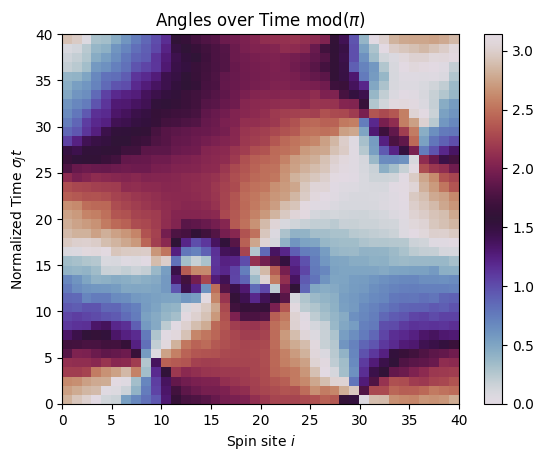

params = [1.  0.4]


In [195]:
identity = 201
slice_viz(histories[identity][100])
print(f'params = {str(params[identity])}')


## 1: Coloured noise?

## Spatial Correlations

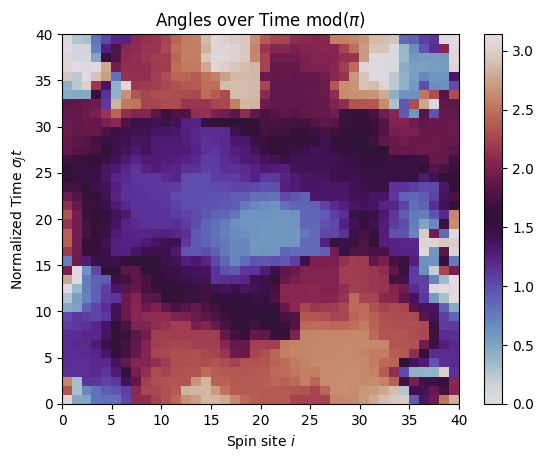

In [198]:
slice_viz(histories[10, 100])

In [223]:
def correlation_x(slice, x):
    values = []
    for i in range(N):
        values.append([np.exp(2*1j*(slice[i, j] - slice[i, (j+x)%N])) for j in range(N)])
    return np.abs(np.mean(values)), np.std(values)


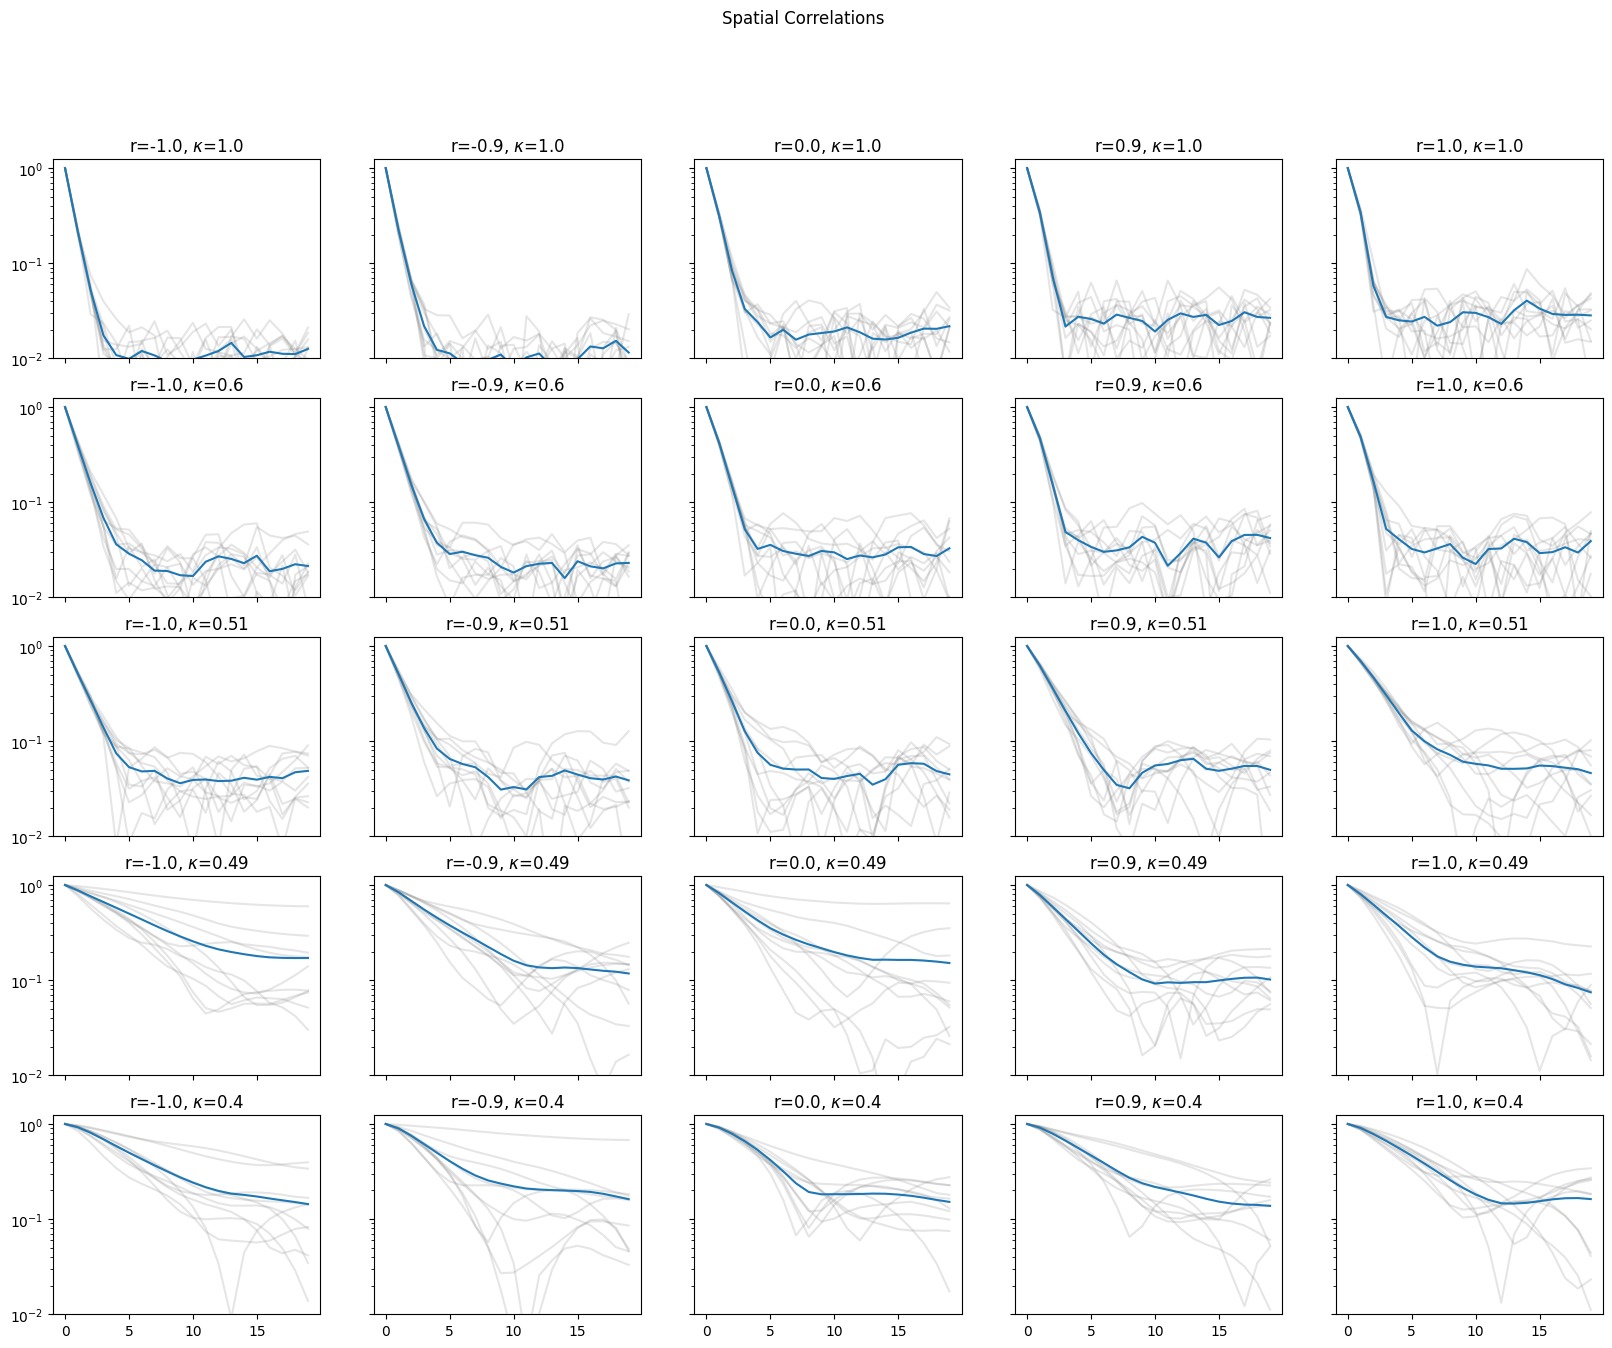

In [222]:

N=40
fix, axs = plt.subplots(5,5, sharex=True, sharey=True, figsize=(20,15))

for x in range(5):
    for y in range(5):
        c_x_graph = []
        for count in range(10):
            his = histories[10*(5*x+y)+count]
            r, kappa = params[10*(5*x+y)+count] 
            corrs = [correlation_x(his, x)[0] for x in range(20)]
            c_x_graph.append(corrs)
            axs[4-y,x].plot(corrs, alpha=0.2, color='grey')
            axs[4-y,x].set_yscale('log')
            axs[4-y,x].set_ylim(bottom=10**(-2))
            axs[4-y,x].set_title(f'r={r}, $\kappa$={kappa}')
            #axs[4-y,x].set_xscale('log')
        avg = np.mean(c_x_graph, axis=0)
        axs[4-y,x].plot(avg)

plt.suptitle('Spatial Correlations')
plt.show()

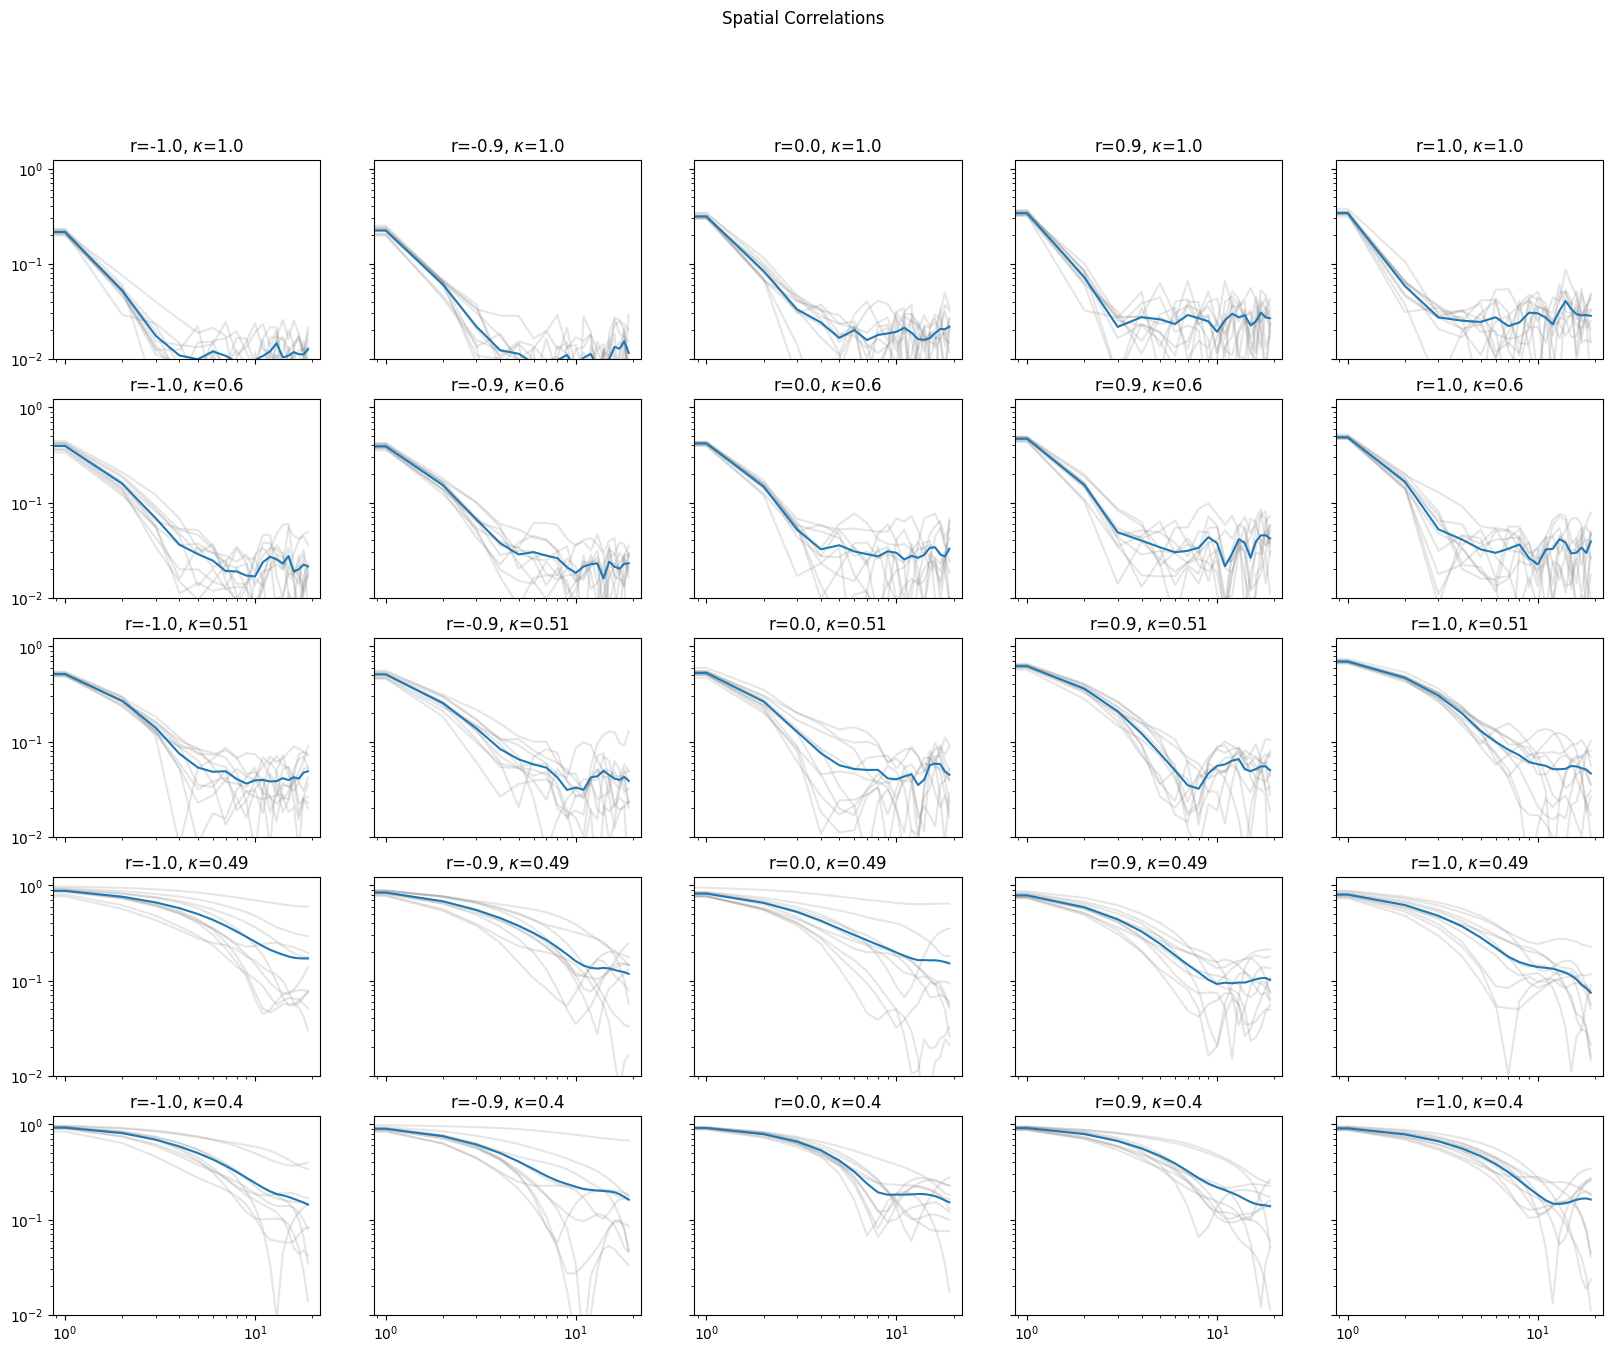

In [486]:

N=40
fix, axs = plt.subplots(5,5, sharex=True, sharey=True, figsize=(20,15))

for x in range(5):
    for y in range(5):
        c_x_graph = []
        for count in range(10):
            his = histories[10*(5*x+y)+count]
            r, kappa = params[10*(5*x+y)+count] 
            corrs = [correlation_x(his, x)[0] for x in range(20)]
            c_x_graph.append(corrs)
            axs[4-y,x].plot(corrs, alpha=0.2, color='grey')
            axs[4-y,x].set_yscale('log')
            axs[4-y,x].set_ylim(bottom=10**(-2))
            axs[4-y,x].set_title(f'r={r}, $\kappa$={kappa}')
            axs[4-y,x].set_xscale('log')
        avg = np.mean(c_x_graph, axis=0)
        axs[4-y,x].plot(avg)

plt.suptitle('Spatial Correlations')
plt.show()

## Are Vortices conserved?

In [5]:
def slice_viz_mod(history, cmap='twilight', max=2*np.pi, min=0):
    fix, ax = plt.subplots(1,1)
    ax.set_xlabel('Spin coordinate $x$')
    ax.set_ylabel('Spin coordinate $y$')
    ax.set_title('Angles over Time mod($\pi$)')
    col = ax.pcolor(history, cmap=cmap, vmin=min, vmax=max)
    plt.colorbar(mappable=col)
    plt.show()


In [49]:
N=200
chain = Chain_2D(N, r=0.0, kappa=0.4)
his = chain.record_at_steady_state(T=100, dT=0.3, t=10, dt=0.1, mod_pi=False)


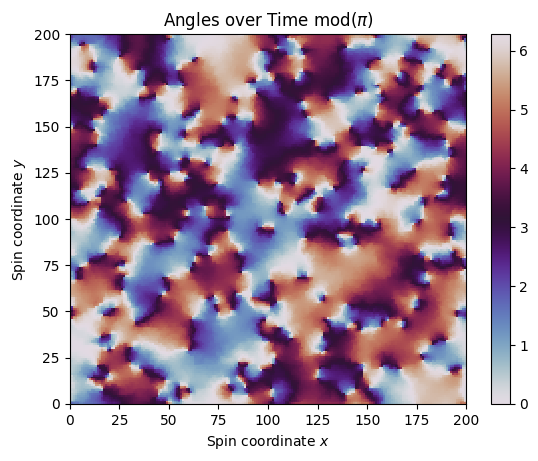

In [50]:

slice_viz_mod(his[-1])

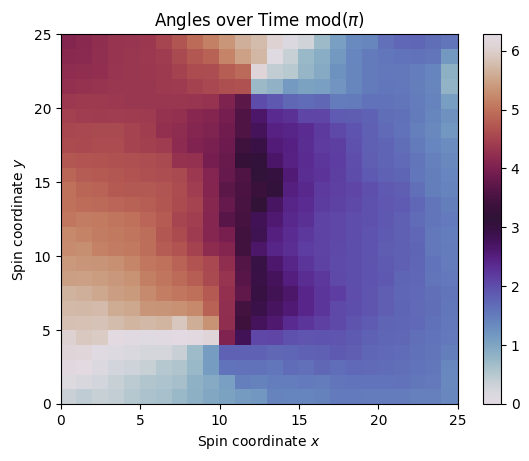

In [58]:
slice_viz_mod(his[-1][25:50, 50:75])

In [6]:
def coords_circulation(x,y):
    return [(x+1, y), (x+1, y-1), (x, y-1), (x-1, y-1), (x-1, y), (x-1, y+1), (x, y+1), (x+1, y+1)]
    

In [7]:
def circulation(slice,x,y, sign=1):
    N = np.shape(slice)[0]
    tot = []
    for i in range(8):

        coords = coords_circulation(x,y)[i]
        prev_coords = coords_circulation(x,y)[i-1]
        tot.append((slice[coords[0]%N, coords[1]%N] - slice[prev_coords[0]%N, prev_coords[1]%N])%(2*np.pi)-np.pi)
    if sign==3:
        if np.abs(np.sum(tot)/(6*np.pi)) >= 0.9:
            return np.sum(tot)/(6*np.pi)
        else:
            return 0
    if sign==2:
        if np.abs(np.sum(tot)/(6*np.pi)) >= 0.9:
            return 1
        else:
            return 0
    else:
        if sign*np.sum(tot)/(6*np.pi) >= 0.9:
            return np.sign(np.sum(tot))
        else:
            return 0


In [8]:
from scipy.ndimage import label
def count_vortices(image):
    N = np.shape(image)[0]
    pos_vortices = [[np.abs(circulation(image, y, x, sign=1)) for x in range(N)] for y in range(N)]
    neg_vortices = [[np.abs(circulation(image, y, x, sign=-1)) for x in range(N)] for y in range(N)]
    structure = np.ones((3, 3), dtype=int)
    labeled, pos_count = label(pos_vortices, structure)
    labeled2, neg_count = label(neg_vortices, structure)
    return pos_count, neg_count

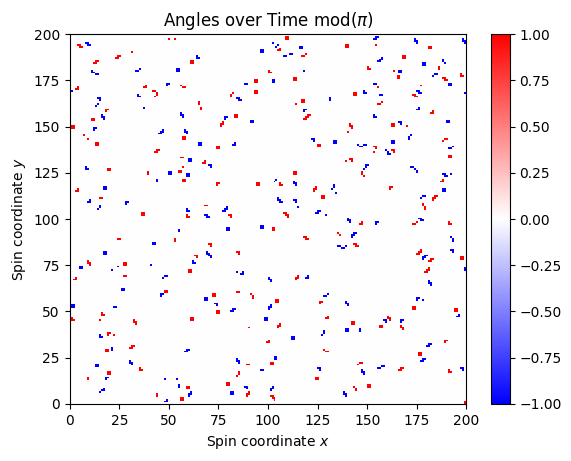

In [62]:
his_circulation = [[(circulation(his[-1], y, x, sign=3)) for x in range(N)] for y in range(N)]
slice_viz_mod(np.array(his_circulation), cmap='bwr', max=1, min=-1)

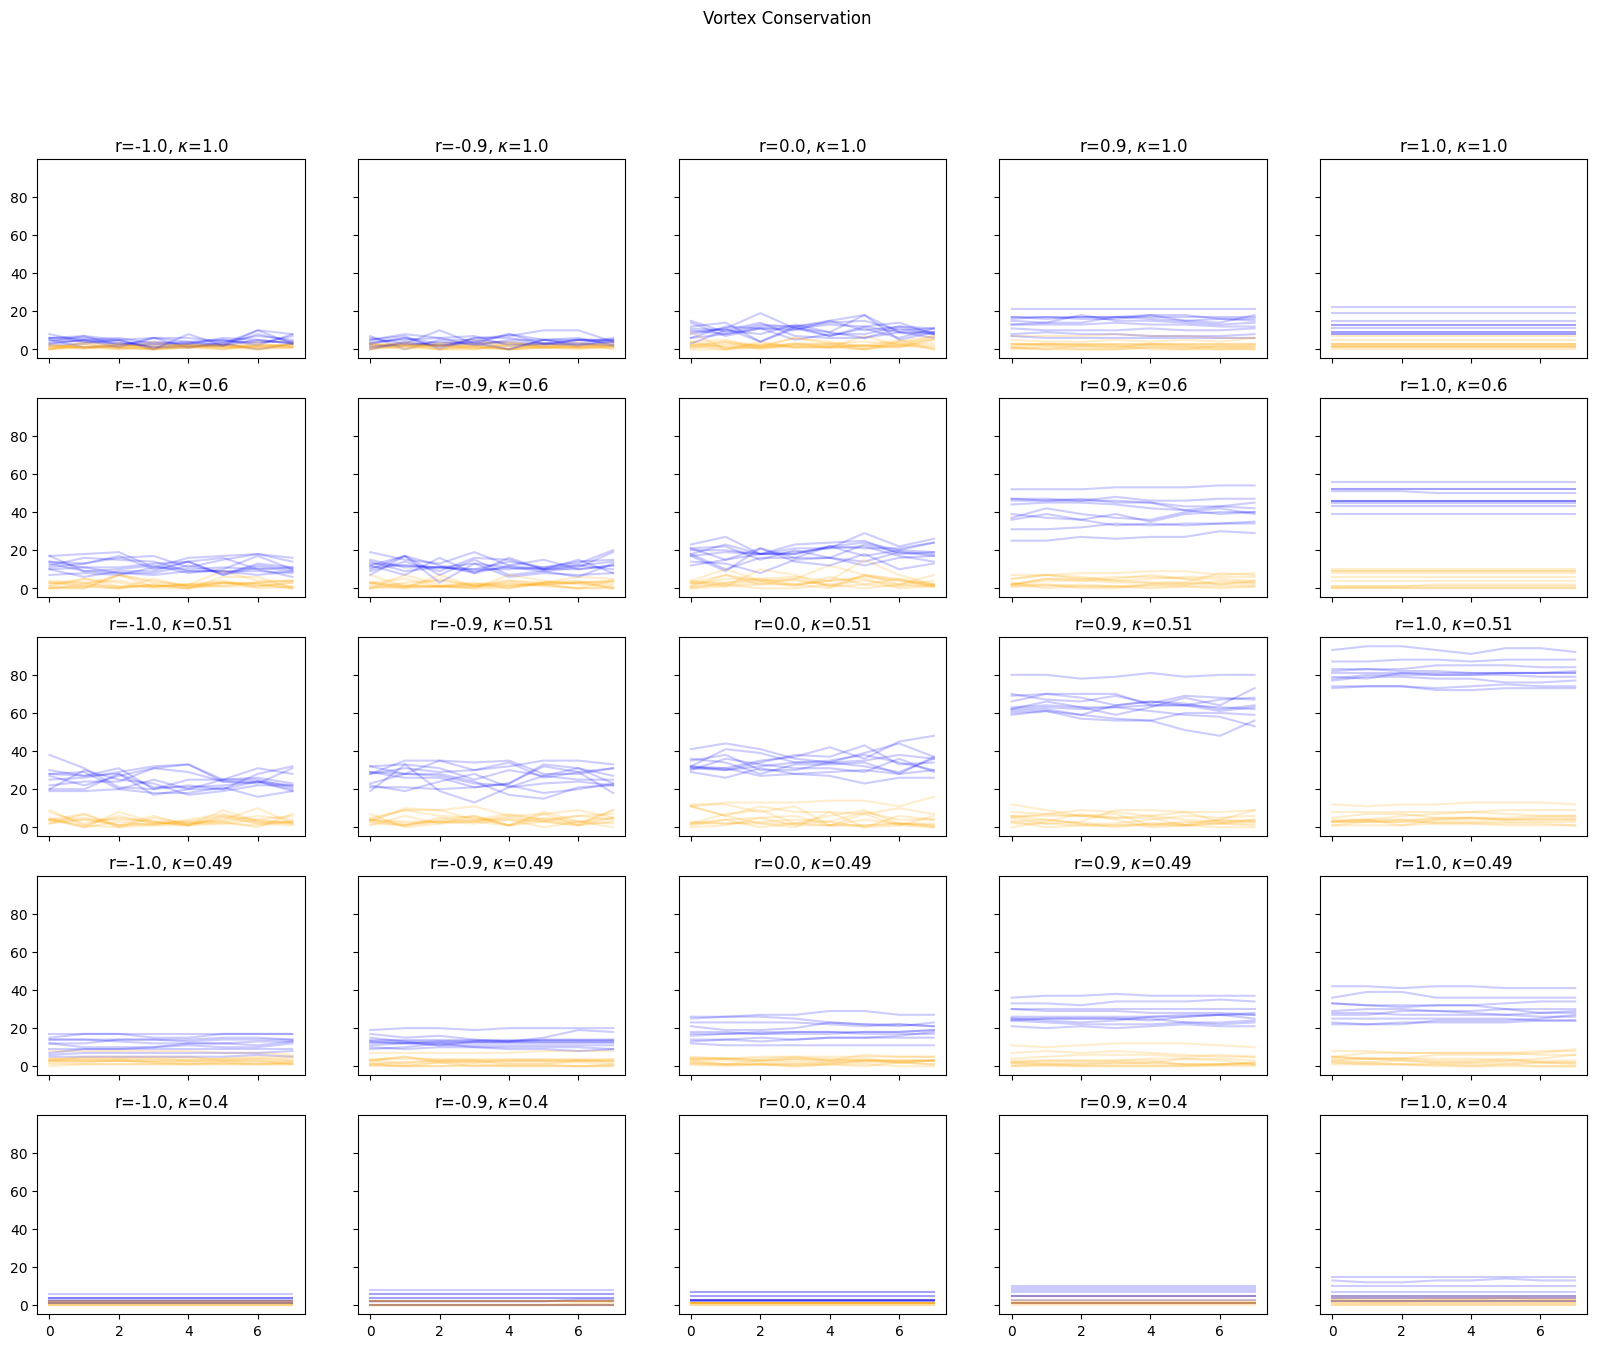

In [491]:
params = np.load('params.npy')
histories = np.load('histories.npy')

N=40
fix, axs = plt.subplots(5,5, sharex=True, sharey=True, figsize=(20,15))

for x in range(5):
    for y in range(5):
        vortex_avg = []
        
        for count in range(10):
            his = histories[10*(5*x+y)+count][::50]
            r, kappa = params[10*(5*x+y)+count] 

            vortices_plus = [count_vortices(his[i])[0] for i in range(his.shape[0])]
            vortices_minus = [count_vortices(his[i])[1] for i in range(his.shape[0])]

            vortices_sum = np.add(vortices_plus, vortices_minus)
            vortices_diff = np.abs(np.subtract(vortices_plus, vortices_minus))


            axs[4-y,x].plot(vortices_sum, alpha=0.2, color='blue')
            axs[4-y,x].plot(vortices_diff, alpha=0.2, color='orange')
            axs[4-y,x].set_title(f'r={r}, $\kappa$={kappa}')


plt.suptitle('Vortex Conservation')
plt.show()

# Vortex Counter

In [9]:
def count_vortices(image):
    N = np.shape(image)[0]
    pos_vortices = [[np.abs(circulation(image, y, x, sign=1)) for x in range(N)] for y in range(N)]
    neg_vortices = [[np.abs(circulation(image, y, x, sign=-1)) for x in range(N)] for y in range(N)]
    structure = np.ones((3, 3), dtype=int)
    pos_labelled, pos_count = label(pos_vortices, structure)
    pos = len([i for i in np.unique(pos_labelled, return_counts=True)[1] if (i>1 and i<20)])

    neg_labelled, neg_count = label(neg_vortices, structure)
    neg = len([i for i in np.unique(neg_labelled, return_counts=True)[1] if (i>1 and i<20)])


    return pos, neg

In [82]:
print(count_vortices(his[-1]))

(141, 141)


In [86]:
N=50
chain = Chain_2D(N, r=0.0, kappa=0.4)
small_hisory = chain.record_at_steady_state(T=0, dT=0.3, t=1000, dt=0.1, mod_pi=False)[::5]

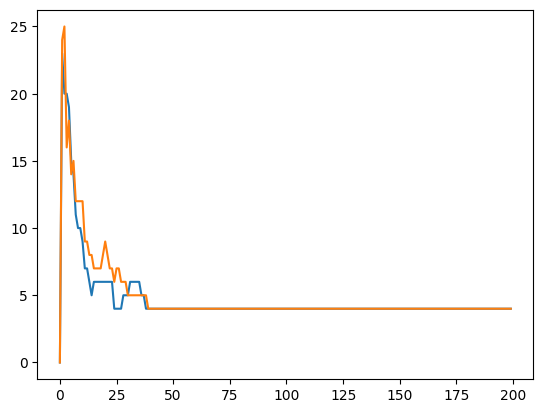

In [89]:
plt.plot([count_vortices(small_hisory[i]) for i in range(int(1000/5))])

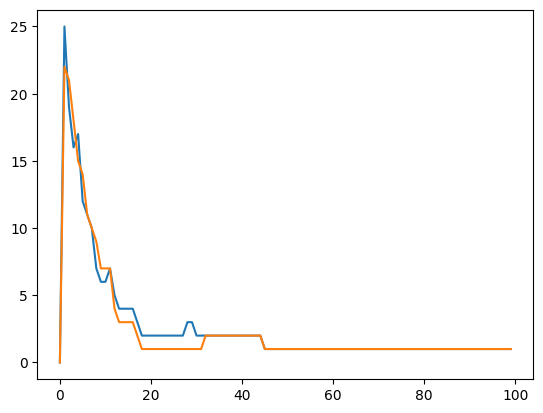

In [91]:
N=50
t=500
chain = Chain_2D(N, r=-1.0, kappa=0.4)
small_hisory = chain.record_at_steady_state(T=0, dT=0.3, t=t, dt=0.1, mod_pi=False)[::5]

plt.plot([count_vortices(small_hisory[i]) for i in range(int(t/5))])

In [108]:
N=50
t=1100
series = []
for i in range(10):
    chain = Chain_2D(N, r=1.0, kappa=0.4)
    small_hisory = chain.record_at_steady_state(T=0, dT=0.3, t=t, dt=0.2, mod_pi=False)[::5]
    series.append([np.sum(np.array(count_vortices(small_hisory[i]))) for i in range(int(t/5))])

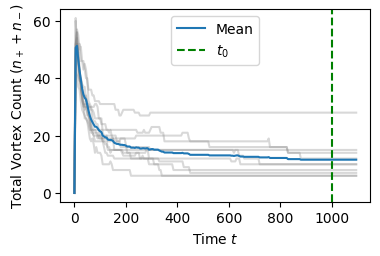

In [169]:
plt.rcParams["figure.figsize"] = (4,2.5)
for i in range(10):
    plt.plot(range(0, 1100, 5), series[i], color='grey', alpha=0.3)
plt.plot(range(0, 1100, 5), np.mean(np.array(series), axis=0), label='Mean')
plt.xlabel('Time $t$')
plt.ylabel('Total Vortex Count $(n_+ + n_-)$')
plt.axvline(x = 1000, color = 'green', label = '$t_0$', ls='--')
plt.legend()
plt.rcParams["figure.figsize"] = (6.4,4.8)

In [50]:
def measure_stable_vortices(r, kappa):
    N=50
    chain = Chain_2D(N, r=r, kappa=kappa)
    small_history = chain.record_at_steady_state(T=900, dT=0.2, t=100, dt=0.05, mod_pi=False)
    p, n = count_vortices(small_history[-1])

    return p+n, abs(p-n)

In [52]:
rs = np.linspace(-1, 1, 11)
kappas = np.linspace(0, 0.7, 8)

measured_array_sum = []
measured_array_diff = []
for r in rs:
    r_vortices_sum = []
    r_vortices_diff = []
    for kappa in kappas:
        ar = np.array([measure_stable_vortices(r=r, kappa=kappa) for i in range(10)])
        sum, diff = np.mean(ar, axis=0)
        r_vortices_sum.append(sum)
        r_vortices_diff.append(diff)
        print(f'done r={r}, kappa={kappa}')
    measured_array_sum.append(r_vortices_sum)
    measured_array_diff.append(r_vortices_diff)
    print(f'done r={r}')

np.save('vortex_counts_sum', measured_array_sum)
np.save('vortex_counts_diff', measured_array_diff)

done r=-1.0, kappa=0.0
done r=-1.0, kappa=0.09999999999999999
done r=-1.0, kappa=0.19999999999999998
done r=-1.0, kappa=0.3
done r=-1.0, kappa=0.39999999999999997
done r=-1.0, kappa=0.49999999999999994
done r=-1.0, kappa=0.6
done r=-1.0, kappa=0.7
done r=-1.0
done r=-0.8, kappa=0.0
done r=-0.8, kappa=0.09999999999999999
done r=-0.8, kappa=0.19999999999999998
done r=-0.8, kappa=0.3
done r=-0.8, kappa=0.39999999999999997
done r=-0.8, kappa=0.49999999999999994
done r=-0.8, kappa=0.6
done r=-0.8, kappa=0.7
done r=-0.8
done r=-0.6, kappa=0.0
done r=-0.6, kappa=0.09999999999999999
done r=-0.6, kappa=0.19999999999999998
done r=-0.6, kappa=0.3
done r=-0.6, kappa=0.39999999999999997
done r=-0.6, kappa=0.49999999999999994
done r=-0.6, kappa=0.6
done r=-0.6, kappa=0.7
done r=-0.6
done r=-0.3999999999999999, kappa=0.0
done r=-0.3999999999999999, kappa=0.09999999999999999
done r=-0.3999999999999999, kappa=0.19999999999999998
done r=-0.3999999999999999, kappa=0.3
done r=-0.3999999999999999, kappa=0.

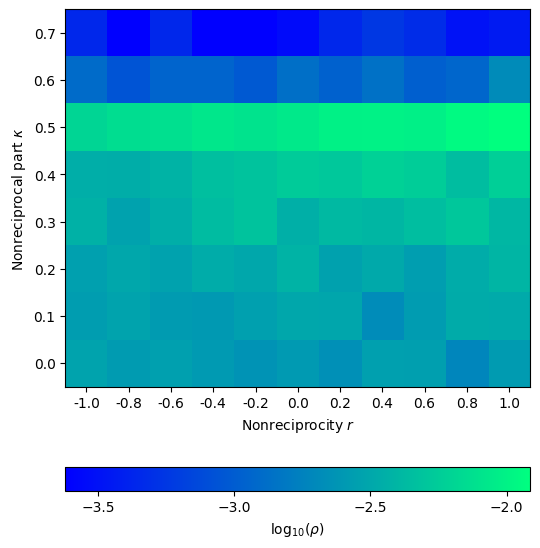

In [172]:
plt.figure(figsize=(6, 7))
N=50
measured_array = np.load('vortex_counts_sum.npy')/(N**2)
plt.imshow(np.log10(np.flip(np.transpose(measured_array), 0)), cmap='winter', interpolation='none', aspect='auto')
plt.yticks(np.flip(kappas)*10, labels=np.round(kappas, 3))
plt.xticks((rs)*5+5, labels=np.round(rs, 3))
plt.xlabel('Nonreciprocity $r$')
plt.ylabel('Nonreciprocal part $\kappa$')
plt.colorbar(label=r'log$_{10}(\rho)$ ', ticks=[-3.5, -3, -2.5, -2], location='bottom')
plt.show()

/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_77430/3861208142.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.flip(np.transpose(measured_array_diff), 0)), cmap='winter', interpolation='none', aspect='auto')


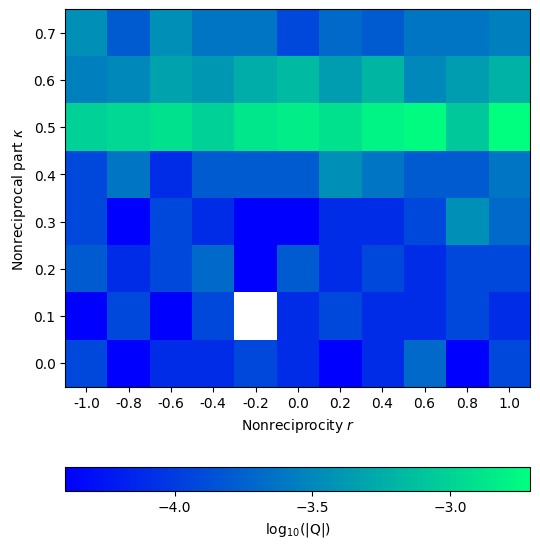

In [173]:
N=50
plt.figure(figsize=(6, 7))
measured_array_diff = np.load('vortex_counts_diff.npy')/(N**2)
plt.imshow(np.log10(np.flip(np.transpose(measured_array_diff), 0)), cmap='winter', interpolation='none', aspect='auto')
plt.yticks(np.flip(kappas)*10, labels=np.round(kappas, 3))
plt.xticks((rs)*5+5, labels=np.round(rs, 3))
plt.xlabel('Nonreciprocity $r$')
plt.ylabel('Nonreciprocal part $\kappa$')
plt.colorbar(label='log$_{10}$(|Q|)', ticks=[-4.5, -4, -3.5, -3], location='bottom')
plt.show()

In [134]:
vortices_along_PT = [[measure_stable_vortices(0, kappa)[0] for kappa in np.linspace(0.45, 0.55, )] for i in range(10)]

(0.0, 0.012)

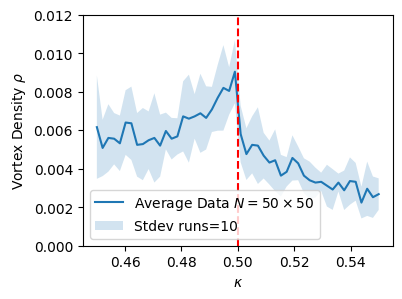

In [174]:
fig = plt.figure(figsize=(4,3))
mean = np.mean(vortices_along_PT, axis=0)/N**2
std = np.std(vortices_along_PT, axis=0)/N**2
plt.plot(np.linspace(0.45, 0.55), mean, label=r'Average Data $N=50 \times 50$')
plt.fill_between(np.linspace(0.45, 0.55), mean+std, mean-std, alpha=0.2, label='Stdev runs=10')
plt.ylabel(r'Vortex Density $\rho$')
plt.xlabel('$\kappa$')
plt.vlines(0.5, color='red', ls='--', ymin=0, ymax=0.012)#, label='$\kappa=1/2$')
plt.legend(loc='lower left')
plt.ylim((0, 0.012))

In [ ]:
params = np.load('params.npy')
histories = np.load('histories.npy')

N=40
fix, axs = plt.subplots(5,5, sharex=True, sharey=True, figsize=(20,15))

for x in range(5):
    for y in range(5):
        vortex_avg = []
        
        for count in range(10):
            his = histories[10*(5*x+y)+count][::50]
            r, kappa = params[10*(5*x+y)+count] 

            vortices_plus = [count_vortices(his[i])[0] for i in range(his.shape[0])]
            vortices_minus = [count_vortices(his[i])[1] for i in range(his.shape[0])]

            vortices_sum = np.add(vortices_plus, vortices_minus)
            vortices_diff = np.abs(np.subtract(vortices_plus, vortices_minus))


            axs[4-y,x].plot(vortices_sum, alpha=0.2, color='blue')
            axs[4-y,x].plot(vortices_diff, alpha=0.2, color='orange')
            axs[4-y,x].set_title(f'r={r}, $\kappa$={kappa}')


plt.suptitle('Vortex Conservation')
plt.show()